#No. Of Images Selected For Each Class is 400 and 2 augumentation images are created for each class, because of less compute power.

Facing session crash, all  RAM used for higher data.



| Task                | Sub-task                       | Done/Not Done |
|---------------------|--------------------------------|---------------|
| Data Preprocessing  | Scaling and Resizing           | Done          |
|                     | Image Augmentation             | Done          |
|                     | Train and test data handled    | Done          |
|                     | Gaussian Blur                  | Done          |
| Model Trained       | Training Time                  | Done ( with GPU approx 2 minutes and without CPU 52 minutes )         |
| AUC and Confusion   | Matrix Computed                | Done          |
| Overfitting/Underfitting| checked and handled        | Done          |
| Empirical Tuning    | Interpretability Implemented   | Not Done          |
| 1st Round of Tuning | Model is slightly underfit bacause train and test accuracy are 64 and 67. To handle this issue I added more additional layers and drop out           | Done          |
| 2nd Round of Tuning | In Model 2 overfitting happened so I added more layers and slightly high drop out        | Done          |


Ref:- https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

Ref:- Girish Work

In [4]:
#Mounting the google drive for data
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [10]:
!unzip /content/drive/MyDrive/Data/FaceExpressions.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Sad/0a12a7e998fa7abde73e79ce2a74477bdc6f5dd010da05231f4c3330.jpg  
  inflating: dataset/Sad/0a1370fc7e34586d5f134694c9d1e79ed4cce9e59684077ae5061db8.png  
  inflating: dataset/Sad/0a14abb2a25753914205e88e870054918de36219552002f3144b8455.jpg  
  inflating: dataset/Sad/0a15eede4e05e13f70f6540c4167282f9a488cc318005c8693c49433.jpg  
  inflating: dataset/Sad/0a163aa46984ad37b58aa6b8175dca9b1007a3066099d18f4dda6f78.jpg  
  inflating: dataset/Sad/0a1833eb2427bd8c1ddd3b9c020c6233a3671763e21b1e08b5afa41f.jpg  
  inflating: dataset/Sad/0a19842e87935fbd2c45a7042e4bb8d1d3816476e8a6b7e8f41205d8.jpg  
  inflating: dataset/Sad/0a1d613237e9af295213c61e1c2b9d7fd211fad638c522afb9548901.jpg  
  inflating: dataset/Sad/0a1d86074a08f9bf55858cf90eaaee6f1e0362d97f08cbaa161e30e0.jpg  
  inflating: dataset/Sad/0a22b8d3b2fbcbebb6a4be7dad0a37b92983e8afe42b4d48cded4e45.jpg  
  inflating: dataset/Sad/0a285a2a07f0f8daaa0a821e30ad2e558ddc18f2589a

#Importing the Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
import cv2
import os
import zipfile
import matplotlib.pyplot as plt
import os
import PIL
import keras
import tensorflow as tf
from keras import layers, models
from keras.applications import EfficientNetB0
import time
from IPython import display
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import roc_auc_score, roc_curve

#path to the directories
categories = ['Angry','Happy','Neutral','Sad','Surprise']

#Set the image size
IMAGE_SIZE = 224

In [2]:
# Initialize ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

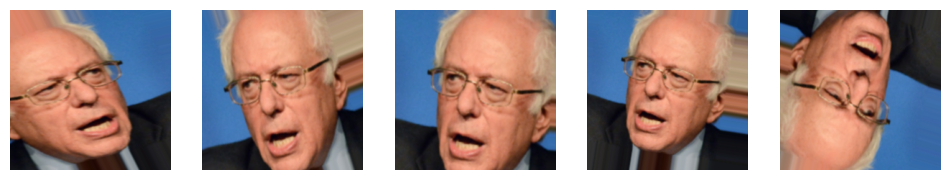

In [3]:
img = load_img("/content/dataset/Angry/00a7cb9cf18d3a015a9e932952f942fd4bcad8044bcef5e0c05de51d~angry.jpg",target_size=(IMAGE_SIZE, IMAGE_SIZE))
x = img_to_array(img)
blur = cv2.GaussianBlur(x,(3,3),0)
blur = blur.reshape((1,) + blur.shape)
augmented_images = []
for batch in datagen.flow(blur, batch_size=1):
  augmented_images.append(array_to_img(batch[0], scale=True))
  if len(augmented_images) >= 6:  # Generate 9 augmented images
    break

# Display some images
fig = plt.figure(figsize=(12, 6))  # Adjust width and height as needed
num_images_to_display = 5  # Change the number of images you want to display
for i in range(min(num_images_to_display, len(augmented_images))):
    plt.subplot(1, num_images_to_display, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')

plt.show()


##Performing Gaussian Blur and Image augumentation and resizing the image to 224 * 224 pixel and Scaling the image

In [3]:
import os
from PIL import Image
data = []

#Method for creating the training data from images folder of all the classes
def load_images_from_folder(folder_path):
  for category in categories:
    class_num = categories.index(category)
    img_path = f"{folder_path}{category}/"
    print(img_path)
    count = 0
    for img in os.listdir(img_path):
      try:
        #Resizing the image
        image = load_img(os.path.join(img_path,img),target_size=(IMAGE_SIZE, IMAGE_SIZE))
        #Rescaling the image
        x = img_to_array(image)/255.0

        #Performing Gaussain Blur with kernel size 5*5
        blur = cv2.GaussianBlur(x,(5,5),0)
        blur = blur.reshape((1,) + blur.shape)
        # Generate augmented images
        augmented_images = []
        for batch in datagen.flow(blur, batch_size=1):
            augmented_images.append([array_to_img(batch[0], scale=True),class_num])
            if len(augmented_images) >= 2:  # Generate 9 augmented images
                break
        count = count+1
        data.extend(augmented_images)
        if count == 400:
          count = 0
          print('count 500')
          break
      except:
        print(f"Unable to load image: {img_path}")
  return data

folder_path = "/content/dataset/"
images = load_images_from_folder(folder_path)

/content/dataset/Angry/
count 500
/content/dataset/Happy/
count 500
/content/dataset/Neutral/
count 500
/content/dataset/Sad/
count 500
/content/dataset/Surprise/
count 500


In [7]:
import pandas as pd
# Creating a DataFrame from the list
df = pd.DataFrame(images, columns=['images', 'labels'])

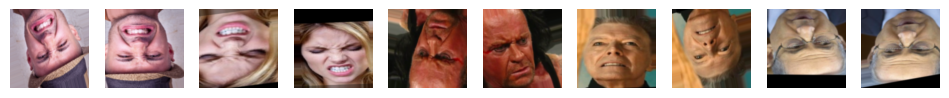

In [4]:
# Display some images
fig = plt.figure(figsize=(12, 6))  # Adjust width and height as needed
num_images_to_display = 10  # Change the number of images you want to display
for i in range(min(num_images_to_display, len(images))):
    plt.subplot(1, num_images_to_display, i+1)
    plt.imshow(array_to_img(images[i][0]))
    plt.axis('off')

plt.show()

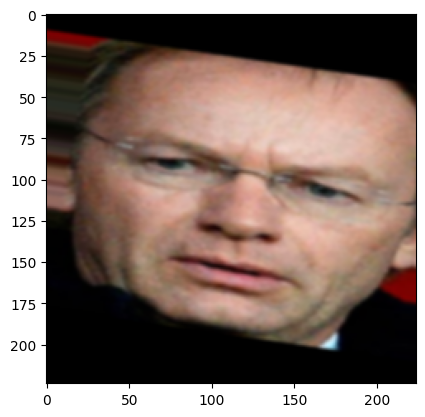

In [ ]:
plt.imshow(df['images'][0])
plt.show()

In [4]:
#shuffling the data to maintain each class frequency
import random

random.shuffle(images)

In [5]:
X=[]
Y=[]

#Separating the data and class labels for X-rays
for features,label in images:
  X.append(img_to_array(features))
  Y.append(label)

In [6]:
# printing the size of X
print(len(X))
print(len(Y))


#Reshaping the image array with image size
X = np.array(X).reshape(-1,IMAGE_SIZE,IMAGE_SIZE,3)
Y = np.array(Y)
print(X.shape)

4000
4000
(4000, 224, 224, 3)


In [7]:
from sklearn.model_selection import train_test_split

# Assuming X contains your features and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#Model Building
##Model 1 with one additional layer of size 256

In [ ]:
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

# Add an additional dense layer
x = layers.Dense(256, activation="relu")(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(5, activation="softmax", name="pred")(x)

# Compile
model = keras.Model(inputs, outputs, name="EfficientNet")
optimizer = keras.optimizers.Adam(learning_rate=1e-2)

batch_size = 50
#Training the model
model.compile(optimizer = optimizer,
              loss ='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_1[0

#Model Training

In [ ]:
hist = model.fit(X_train,y_train,batch_size=batch_size,validation_split=0.2, epochs=10)

Epoch 1/10
52/52 [==============================] - 21s 205ms/step - loss: 1.4456 - accuracy: 0.5129 - val_loss: 1.2285 - val_accuracy: 0.5188
Epoch 2/10
52/52 [==============================] - 7s 129ms/step - loss: 1.0759 - accuracy: 0.5949 - val_loss: 1.1537 - val_accuracy: 0.5781
Epoch 3/10
52/52 [==============================] - 6s 121ms/step - loss: 0.9454 - accuracy: 0.6582 - val_loss: 1.1649 - val_accuracy: 0.5734
Epoch 4/10
52/52 [==============================] - 6s 124ms/step - loss: 0.8508 - accuracy: 0.6934 - val_loss: 1.1794 - val_accuracy: 0.5844
Epoch 5/10
52/52 [==============================] - 6s 122ms/step - loss: 0.7536 - accuracy: 0.7320 - val_loss: 1.3170 - val_accuracy: 0.5906
Epoch 6/10
52/52 [==============================] - 6s 124ms/step - loss: 0.6651 - accuracy: 0.7660 - val_loss: 1.3130 - val_accuracy: 0.5672
Epoch 7/10
52/52 [==============================] - 6s 120ms/step - loss: 0.6306 - accuracy: 0.7781 - val_loss: 1.3012 - val_accuracy: 0.6062
Epoch


#History Plot of training and validation loss with 80 and 20 split.

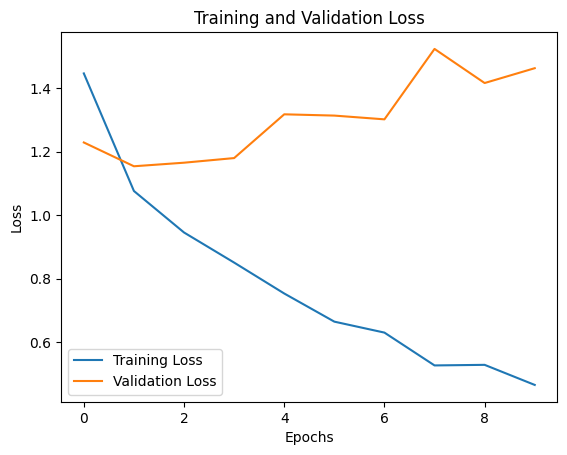

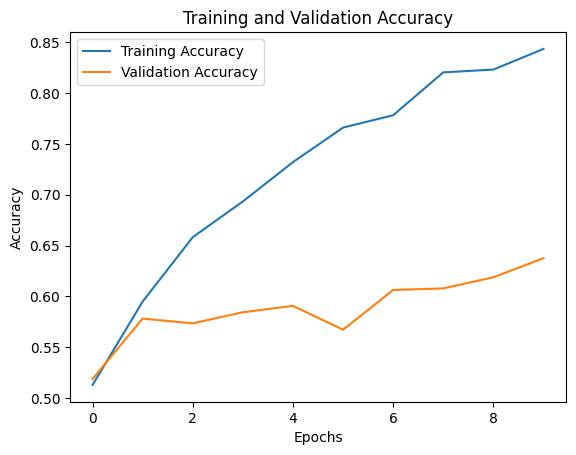

In [ ]:
# Plot training loss vs. validation loss
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training accuracy vs. validation accuracy
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/models/efficient_model_transfer_4000_images.model')

In [5]:
model = tf.keras.models.load_model('/content/drive/MyDrive/models/efficient_model_transfer_4000_images.model')

#Model Evaluation

##Train and Test Data Accuracy

In [ ]:
batch_size = 50
#Calculating the accuracy on train data
loss, acc = model.evaluate(X_train,y_train,batch_size=batch_size)
print("Train Accuracy:-> {}".format(acc))

64/64 [==============================] - 8s 95ms/step - loss: 1.3159 - accuracy: 0.6444
Train Accuracy:-> 0.6443750262260437


In [ ]:
batch_size = 50
#Calculating the accuracy on train data
loss, acc = model.evaluate(X_test,y_test,batch_size=batch_size)
print("Test Accuracy:-> {}".format(acc))

16/16 [==============================] - 2s 99ms/step - loss: 1.1554 - accuracy: 0.6712
Test Accuracy:-> 0.6712499856948853


In [ ]:
#predicting the x_test
y_pred = model.predict(X_test)

print(y_pred.shape)

25/25 [==============================] - 3s 59ms/step
(800, 5)


In [ ]:
#getting the max index based on probability given by softmax
y_prediction = np.argmax(y_pred, axis=1)

#Converting it into pandas series
y_pred_ser = pd.Series(y_prediction)


print(classification_report(y_test,y_pred_ser))

              precision    recall  f1-score   support

           0       0.68      0.69      0.69       152
           1       0.77      0.63      0.69       182
           2       0.63      0.68      0.65       157
           3       0.55      0.68      0.61       150
           4       0.77      0.69      0.73       159

    accuracy                           0.67       800
   macro avg       0.68      0.67      0.67       800
weighted avg       0.68      0.67      0.67       800



In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_ser, labels=[0, 1, 2, 3, 4])

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[105   5  13  22   7]
 [ 15 114  17  24  12]
 [ 10  14 106  20   7]
 [ 15  10  17 102   6]
 [  9   6  15  19 110]]


In [ ]:
# Calculating the AUC Score
auc_score = roc_auc_score(y_test, y_pred,multi_class="ovr")
print(f"AUC Score: {auc_score}")

AUC Score: 0.9003724877452657


#Model Tuning 1 - Above model is slightly underfit to handle underfitting add more layer to make model complex.

##Model 2 with

In [12]:
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
model_2 = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
model_2.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model_2.output)
x = layers.BatchNormalization()(x)


#adding more dropout layer
top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout_1")(x)
x = layers.Dense(128, activation="relu")(x)


x = layers.GlobalAveragePooling2D(name="avg_pool")(model_2.output)
x = layers.BatchNormalization()(x)
# Add an additional dense layer
x = layers.Dense(256, activation="relu")(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(5, activation="softmax", name="pred")(x)

# Compile
model_2 = keras.Model(inputs, outputs, name="EfficientNet")
optimizer = keras.optimizers.Adam(learning_rate=1e-2)

batch_size = 50
#Training the model
model_2.compile(optimizer = optimizer,
              loss ='sparse_categorical_crossentropy',
              metrics=['accuracy'])

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
model_2.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_1[0

In [13]:
hist_2 = model_2.fit(X_train,y_train,batch_size=batch_size,validation_split=0.2, epochs=10)

Epoch 1/10
52/52 [==============================] - 27s 263ms/step - loss: 2.9300 - accuracy: 0.3910 - val_loss: 1.4370 - val_accuracy: 0.4125
Epoch 2/10
52/52 [==============================] - 6s 120ms/step - loss: 1.2063 - accuracy: 0.5543 - val_loss: 1.4804 - val_accuracy: 0.4437
Epoch 3/10
52/52 [==============================] - 6s 125ms/step - loss: 0.8304 - accuracy: 0.6973 - val_loss: 1.3585 - val_accuracy: 0.4797
Epoch 4/10
52/52 [==============================] - 6s 121ms/step - loss: 0.6840 - accuracy: 0.7504 - val_loss: 1.3011 - val_accuracy: 0.4984
Epoch 5/10
52/52 [==============================] - 7s 125ms/step - loss: 0.6737 - accuracy: 0.7574 - val_loss: 1.2133 - val_accuracy: 0.5188
Epoch 6/10
52/52 [==============================] - 6s 121ms/step - loss: 0.6287 - accuracy: 0.7937 - val_loss: 1.3038 - val_accuracy: 0.4953
Epoch 7/10
52/52 [==============================] - 7s 126ms/step - loss: 0.5864 - accuracy: 0.7922 - val_loss: 1.3493 - val_accuracy: 0.5063
Epoch

In [14]:
model_2.save('/content/drive/MyDrive/models/efficient_model_transfer_4000_images_2.1.model')

In [ ]:
model_2.save('/content/drive/MyDrive/models/efficient_model_transfer_4000_images_2.model')

In [9]:
model_2 = tf.keras.models.load_model('/content/drive/MyDrive/models/efficient_model_transfer_4000_images_2.1.model')

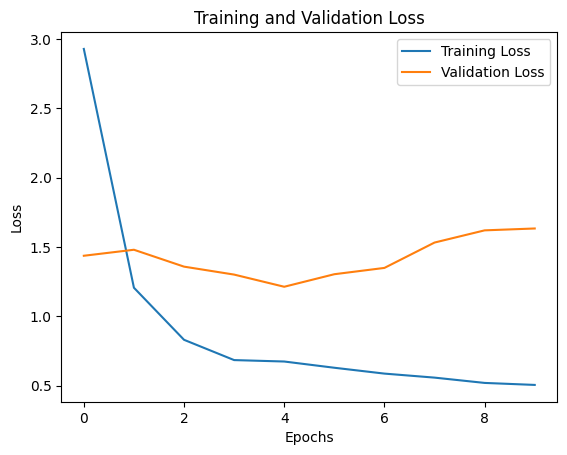

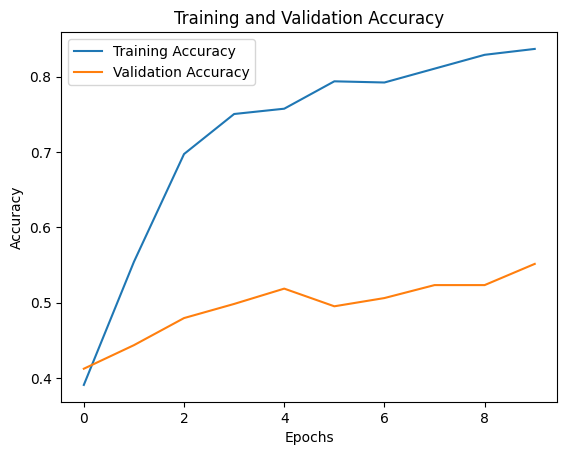

In [15]:
# Plot training loss vs. validation loss
plt.plot(hist_2.history['loss'], label='Training Loss')
plt.plot(hist_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training accuracy vs. validation accuracy
plt.plot(hist_2.history['accuracy'], label='Training Accuracy')
plt.plot(hist_2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#Train And Test Data Accuracy

In [10]:
batch_size = 50
#Calculating the accuracy on train data
loss, acc = model_2.evaluate(X_train,y_train,batch_size=batch_size)
print("Train Accuracy Model 2:-> {}".format(acc))

64/64 [==============================] - 15s 94ms/step - loss: 1.2819 - accuracy: 0.6338
Train Accuracy Model 2:-> 0.6337500214576721


In [11]:
batch_size = 50
#Calculating the accuracy on train data
loss, acc = model_2.evaluate(X_test,y_test,batch_size=batch_size)
print("Test Accuracy Model 2:-> {}".format(acc))

16/16 [==============================] - 2s 93ms/step - loss: 1.3952 - accuracy: 0.6050
Test Accuracy Model 2:-> 0.6050000190734863


In [12]:
#predicting the x_test
y_pred = model_2.predict(X_test)

print(y_pred.shape)

25/25 [==============================] - 5s 57ms/step
(800, 5)


#Model Evaluation

In [13]:
#getting the max index based on probability given by softmax
y_prediction = np.argmax(y_pred, axis=1)

#Converting it into pandas series
y_pred_ser = pd.Series(y_prediction)


print(classification_report(y_test,y_pred_ser))

              precision    recall  f1-score   support

           0       0.58      0.74      0.65       164
           1       0.60      0.65      0.62       152
           2       0.64      0.41      0.50       164
           3       0.57      0.54      0.56       167
           4       0.66      0.69      0.67       153

    accuracy                           0.60       800
   macro avg       0.61      0.61      0.60       800
weighted avg       0.61      0.60      0.60       800



In [14]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_ser, labels=[0, 1, 2, 3, 4])

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[121  10   9  15   9]
 [ 11  99  10  15  17]
 [ 28  30  68  24  14]
 [ 37  13  11  91  15]
 [ 12  14   8  14 105]]


In [15]:
# Calculating the AUC Score
auc_score = roc_auc_score(y_test, y_pred,multi_class="ovr")
print(f"AUC Score: {auc_score}")

AUC Score: 0.8624833548327764


#Model Tuning 2 to handle overfitting adding high dropout of 0.25 and layer size from 64, 128 and 256

In [8]:
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
model_3 = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
model_3.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model_3.output)
x = layers.BatchNormalization()(x)
#adding more dropout layer
top_dropout_rate = 0.25
x = layers.Dropout(top_dropout_rate, name="top_dropout_1")(x)
x = layers.Dense(64, activation="relu")(x)

x = layers.GlobalAveragePooling2D(name="max_pool")(model_3.output)
x = layers.BatchNormalization()(x)
#adding more dropout layer
top_dropout_rate = 0.25
x = layers.Dropout(top_dropout_rate, name="top_dropout_1")(x)
x = layers.Dense(128, activation="relu")(x)

x = layers.GlobalAveragePooling2D(name="max_pool")(model_3.output)
x = layers.BatchNormalization()(x)
#adding more dropout layer
top_dropout_rate = 0.25
x = layers.Dropout(top_dropout_rate, name="top_dropout_1")(x)
x = layers.Dense(256, activation="relu")(x)

top_dropout_rate = 0.25
x = layers.Dropout(top_dropout_rate, name="top_dropout_2")(x)
outputs = layers.Dense(5, activation="softmax", name="pred")(x)

# Compile
model_3 = keras.Model(inputs, outputs, name="EfficientNet")
optimizer = keras.optimizers.Adam(learning_rate=1e-2)

batch_size = 50
#Training the model
model_3.compile(optimizer = optimizer,
              loss ='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
model_3.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][

In [10]:
hist_3 = model_3.fit(X_train,y_train,batch_size=batch_size,validation_split=0.2, epochs=10)

Epoch 1/10
52/52 [==============================] - 25s 252ms/step - loss: 3.1574 - accuracy: 0.3574 - val_loss: 1.4620 - val_accuracy: 0.3906
Epoch 2/10
52/52 [==============================] - 6s 121ms/step - loss: 1.3099 - accuracy: 0.5207 - val_loss: 1.4945 - val_accuracy: 0.4187
Epoch 3/10
52/52 [==============================] - 6s 123ms/step - loss: 1.0114 - accuracy: 0.6148 - val_loss: 1.4396 - val_accuracy: 0.4578
Epoch 4/10
52/52 [==============================] - 6s 123ms/step - loss: 0.9297 - accuracy: 0.6598 - val_loss: 1.3266 - val_accuracy: 0.4578
Epoch 5/10
52/52 [==============================] - 6s 123ms/step - loss: 0.8667 - accuracy: 0.6891 - val_loss: 1.2487 - val_accuracy: 0.5203
Epoch 6/10
52/52 [==============================] - 6s 123ms/step - loss: 0.7550 - accuracy: 0.7191 - val_loss: 1.1903 - val_accuracy: 0.5344
Epoch 7/10
52/52 [==============================] - 6s 124ms/step - loss: 0.7121 - accuracy: 0.7508 - val_loss: 1.2249 - val_accuracy: 0.5000
Epoch

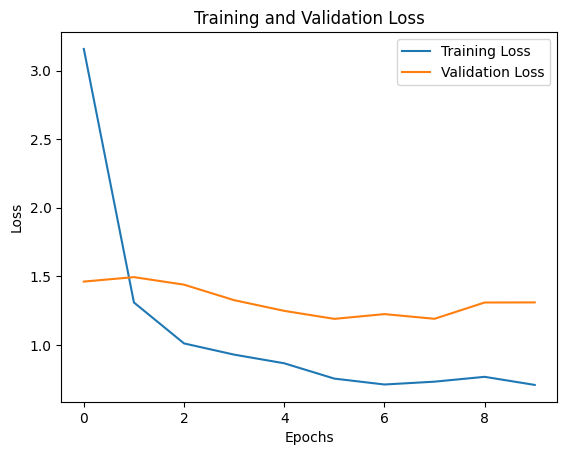

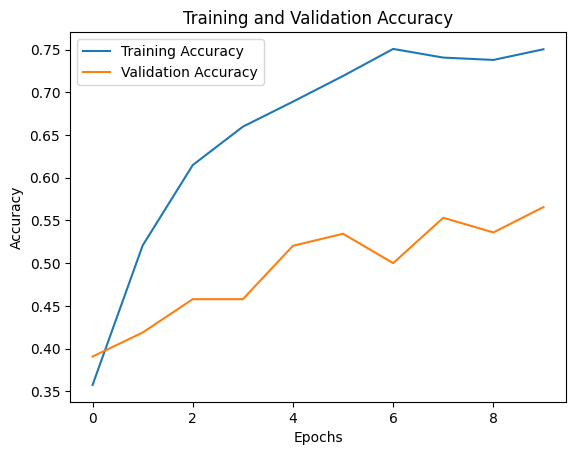

In [11]:
# Plot training loss vs. validation loss
plt.plot(hist_3.history['loss'], label='Training Loss')
plt.plot(hist_3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training accuracy vs. validation accuracy
plt.plot(hist_3.history['accuracy'], label='Training Accuracy')
plt.plot(hist_3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [12]:
model_3.save('/content/drive/MyDrive/models/efficient_model_transfer_4000_images_3.model')

In [8]:
model_3 = tf.keras.models.load_model('/content/drive/MyDrive/models/efficient_model_transfer_4000_images_3.model')

In [9]:
batch_size = 50
#Calculating the accuracy on train data
loss, acc = model_3.evaluate(X_train,y_train,batch_size=batch_size)
print("Train Accuracy Model 3:-> {}".format(acc))

64/64 [==============================] - 13s 94ms/step - loss: 1.0942 - accuracy: 0.6309
Train Accuracy Model 3:-> 0.6309375166893005


In [10]:
batch_size = 50
#Calculating the accuracy on train data
loss, acc = model_3.evaluate(X_test,y_test,batch_size=batch_size)
print("Test Accuracy Model 2:-> {}".format(acc))

16/16 [==============================] - 2s 106ms/step - loss: 1.1357 - accuracy: 0.6237
Test Accuracy Model 2:-> 0.6237499713897705


In [11]:
#predicting the x_test
y_pred = model_3.predict(X_test)

print(y_pred.shape)

25/25 [==============================] - 6s 57ms/step
(800, 5)


#Model Evaluation

In [12]:
#getting the max index based on probability given by softmax
y_prediction = np.argmax(y_pred, axis=1)

#Converting it into pandas series
y_pred_ser = pd.Series(y_prediction)


print(classification_report(y_test,y_pred_ser))

              precision    recall  f1-score   support

           0       0.55      0.64      0.59       166
           1       0.72      0.60      0.66       174
           2       0.56      0.62      0.59       141
           3       0.59      0.51      0.55       156
           4       0.71      0.74      0.72       163

    accuracy                           0.62       800
   macro avg       0.63      0.62      0.62       800
weighted avg       0.63      0.62      0.62       800



In [13]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_ser, labels=[0, 1, 2, 3, 4])

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[106  12  22  16  10]
 [ 22 105  19  14  14]
 [ 20   5  88  18  10]
 [ 28  14  18  80  16]
 [ 17   9   9   8 120]]


In [14]:
# Calculating the AUC Score
auc_score = roc_auc_score(y_test, y_pred,multi_class="ovr")
print(f"AUC Score: {auc_score}")

AUC Score: 0.8668180961865053


#LIME Interpretibility

In [6]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=f01a589359de249e77423e4044777a18a1b0a4fce9c8327a835efef471bc7e30
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [7]:
# predict function for LIME explainer
def prediction_fun(images):
    pred = model.predict(images)
    preds = pred
    for x in preds.argsort()[0][-5:]:
        print(x, categories[x], preds[0,x])
    return pred


In [8]:
from lime import lime_image
from skimage.segmentation import mark_boundaries


def imageLimeInterpreter(random_test_image):
    # Loading the test image and resizing it to fit in cnn_model
    test_image = load_img(random_test_image, target_size=(224, 224))
    # Convert to numpy array and normalize
    test_image = img_to_array(test_image) / 255.0
    #LimeImageExplainer is  an instance of the LIME responsible for generating explaination for image being classified
    img_explainer = lime_image.LimeImageExplainer()
    #creating instance of explainer with this feature to classify the prediction.
    explanation = img_explainer.explain_instance(test_image, prediction_fun, top_labels=5,hide_color=None, num_samples=50)

    # calculating the predicted label and probabilities so that
    predicted_probabilities = model.predict(test_image[np.newaxis, ...])[0]
    predicted_label_index = np.argmax(predicted_probabilities)
    predicted_label = categories[predicted_label_index]

    #this method returns both the highlighted image and a mask indicating the important regions.
    temp, mask = explanation.get_image_and_mask(predicted_label_index, positive_only=True, num_features=5, hide_rest=False)

    # Plot the predicted label and explanation side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot predicted label
    axes[0].text(0.3, 0.3, f"Predicted Label: {predicted_label}", fontsize=12, ha='center')
    axes[0].axis('off')

    # Plot LIME explanation with Lime classification boundary colored differently
    lime_classified_image = mark_boundaries(temp / 2 + 0.5, mask, outline_color=(2, 2, 0))
    axes[1].imshow(lime_classified_image)
    axes[1].text(0.3, 0.03, f"LIME Classification: {predicted_label}", fontsize=11, ha='center', color='red')
    axes[1].axis('off')

    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
4 Surprise 0.0024989937
3 Sad 0.060514882
1 Happy 0.069038324
0 Angry 0.29754692
2 Neutral 0.5704009
1/1 [==============================] - 1s 1s/step
4 Surprise 0.0024876765
3 Sad 0.060305092
1 Happy 0.069143705
0 Angry 0.29738235
2 Neutral 0.57068115
1/1 [==============================] - 1s 1s/step
4 Surprise 0.0024755904
3 Sad 0.06019757
1 Happy 0.06910127
0 Angry 0.29719043
2 Neutral 0.57103515
1/1 [==============================] - 1s 1s/step
4 Surprise 0.0024804475
3 Sad 0.06027623
1 Happy 0.06912561
0 Angry 0.29727787
2 Neutral 0.5708398
1/1 [==============================] - 1s 960ms/step
4 Surprise 0.0024929296
3 Sad 0.060781904
1 Happy 0.068896316
0 Angry 0.2979437
2 Neutral 0.56988513
1/1 [==============================] - 0s 208ms/step


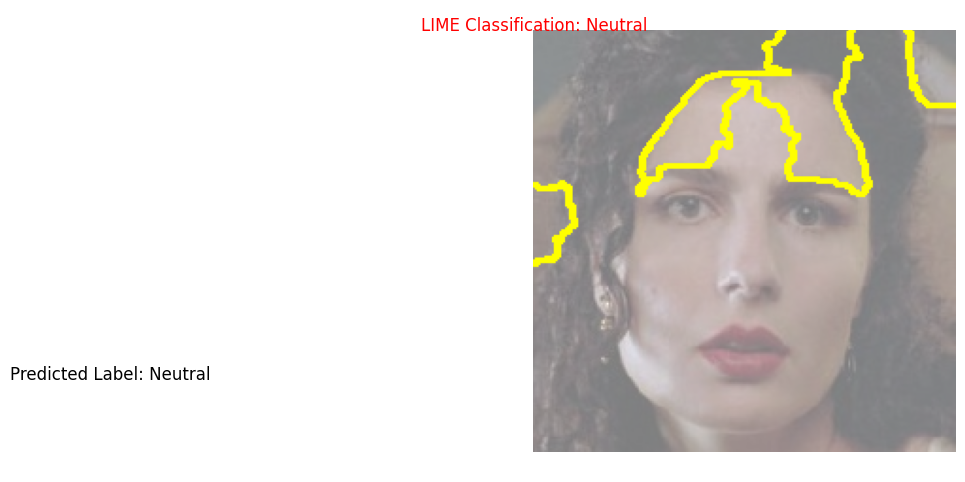

In [14]:
imageLimeInterpreter("/content/dataset/Neutral/000addf312c43df2195d4665da134a119860c413a57b5889c6a1d7aaf.jpg")